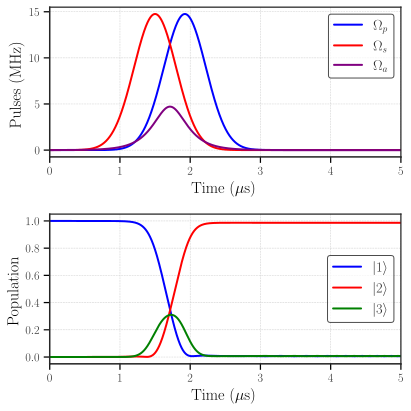

Parámetros óptimos: Omega13 = Omega23 = 14.7570 (MHz)
                    sigma = 0.3000 (μs)
Valor final población |1>: 0.0068
Valor final población |2>: 0.9862
Valor final población |3>: 0.0069
Tiempo para llegar al 99% del valor máximo de p2: 2.2012 μs
Tiempo total de la simulación: 22.7563 segundos


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import matplotlib as mpl
from matplotlib import rcParams
from scipy.integrate import odeint
from scipy.optimize import minimize
import time  
import seaborn as sns

def initialize_plotting(style='whitegrid'):
    import IPython
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import seaborn as sns
 
    # Aplicar el estilo de Seaborn
    sns.set(style=style)

    # Estilos para gráficos
    label_size = 20
    mpl.rcParams['xtick.labelsize'] = label_size 
    mpl.rcParams['ytick.labelsize'] = label_size 
    plt.rc('font', family='serif')  # Fuente serif para el texto
    
    # figuras alta calidad jupyter
    %config InlineBackend.figure_format = 'svg' 
    
    mpl.rcParams.update({'font.size': 16})
    mpl.rcParams['text.usetex'] = True  

def define_operators():
    ket1 = basis(3, 0)  # |1>
    ket2 = basis(3, 1)  # |2>
    ket3 = basis(3, 2)  # |3>
    return ket1, ket2, ket3

def define_sigma_ops(ket1, ket2, ket3):
    sigma_11 = ket1 * ket1.dag()  # |1><1>
    sigma_22 = ket2 * ket2.dag()  # |2><2>
    sigma_33 = ket3 * ket3.dag()  # |3><3>
    sigma_31 = ket3 * ket1.dag()  # |3><1>
    sigma_12 = ket1 * ket2.dag()  # |1><2>
    sigma_21 = ket2 * ket1.dag()  # |2><1>
    sigma_13 = ket1 * ket3.dag()  # |1><3>
    sigma_32 = ket3 * ket2.dag()  # |3><2>
    sigma_23 = ket2 * ket3.dag()  # |2><3>
    return sigma_11, sigma_22, sigma_33, sigma_31, sigma_12, sigma_21, sigma_13, sigma_32, sigma_23

def define_collapse_ops(sigma_11, sigma_22, sigma_33, gamma1, gamma2, gamma3):
    c_ops = [
        np.sqrt(gamma1) * sigma_11,  
        np.sqrt(gamma2) * sigma_22,  
        np.sqrt(gamma3) * sigma_33   
    ]
    return c_ops

def controls(t, args, Omega13, Omega23):
    Omega_p = Omega13 * np.exp(-0.5 * ((t - args['tp']) / args['width']) ** 2)
    Omega_s = Omega23 * np.exp(-0.5 * ((t - args['ts']) / args['width']) ** 2)
    return Omega_p, Omega_s

def control_derivatives(t, args, Omega13, Omega23):
    dOmega_p_dt = Omega13 * np.exp(-0.5 * ((t - args['tp']) / args['width']) ** 2) * (-((t - args['tp']) / args['width'] ** 2))
    dOmega_s_dt = Omega23 * np.exp(-0.5 * ((t - args['ts']) / args['width']) ** 2) * (-((t - args['ts']) / args['width'] ** 2))
    return dOmega_p_dt, dOmega_s_dt

def define_control_funcs(Omega_p, Omega_s, dOmega_p_dt, dOmega_s_dt):
    theta = np.arctan(Omega_p / Omega_s)
    Omega_amp = Omega_s**2 + Omega_p**2
    Omega_a = 2 * (Omega_s * dOmega_p_dt - Omega_p * dOmega_s_dt) / Omega_amp
    dphi_dt = 0.5 * (Omega_s * dOmega_s_dt + Omega_p * dOmega_p_dt) / ((1 + Omega_amp**2) * (Omega_amp**2)**0.5)
    Omega_b = dphi_dt * np.sin(theta)
    Omega_c = dphi_dt * np.cos(theta)
    return Omega_a, Omega_b, Omega_c

def run_simulation(params, ts, tlist, delta, Delta1, gamma1, gamma2, gamma3, sigma, c_ops, psi0, ket1, ket2, ket3):
    Omega0 = params[0]
    Omega13, Omega23 = Omega0, Omega0
    td = np.sqrt(2) * sigma
    tp = ts + td
    args = {'tp': tp, 'ts': ts, 'width': sigma}
    
    Omega_p = lambda t, args: controls(t, args, Omega13, Omega23)[0]
    Omega_s = lambda t, args: controls(t, args, Omega13, Omega23)[1]
    
    dOmega_p_dt = lambda t, args: control_derivatives(t, args, Omega13, Omega23)[0]
    dOmega_s_dt = lambda t, args: control_derivatives(t, args, Omega13, Omega23)[1]

    Omega_a = lambda t, args: define_control_funcs(Omega_p(t, args), Omega_s(t, args), dOmega_p_dt(t, args), dOmega_s_dt(t, args))[0]
    Omega_b = lambda t, args: define_control_funcs(Omega_p(t, args), Omega_s(t, args), dOmega_p_dt(t, args), dOmega_s_dt(t, args))[1]
    Omega_c = lambda t, args: define_control_funcs(Omega_p(t, args), Omega_s(t, args), dOmega_p_dt(t, args), dOmega_s_dt(t, args))[2]

    sigma_11, sigma_22, sigma_33, sigma_31, sigma_12, sigma_21, sigma_13, sigma_32, sigma_23 = define_sigma_ops(ket1, ket2, ket3)

    H0 = delta * sigma_22 + Delta1 * sigma_33
    Hp = (sigma_31 + sigma_13) / 2
    Hs = (sigma_32 + sigma_23) / 2

    Hcd = [
        [0.5j * sigma_21, Omega_a],
        [-0.5j * sigma_12, Omega_a],
        [1j * sigma_31, Omega_b],
        [-1j * sigma_13, Omega_b],
        [-1j * sigma_32, Omega_c],
        [1j * sigma_23, Omega_c]
    ]

    H = [H0, [Hp, Omega_p], [Hs, Omega_s]] + Hcd

    result = mesolve(H, psi0, tlist, c_ops, [basis(3, 0).proj(), basis(3, 1).proj(), basis(3, 2).proj()], args=args)
    p1_final = np.abs(result.expect[0][-1])
    p2_final = np.abs(result.expect[1][-1])
    p3_final = np.abs(result.expect[2][-1])
    return p1_final**2 + (1 - p2_final)**2 + p3_final**2

def plot_results(tlist, Omega_p_values, Omega_s_values, Omega_a_values, p1_opt, p2_opt, p3_opt):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), tight_layout=True)

    ax1.plot(tlist, Omega_p_values, label=r"$\Omega_p$", color='blue', linewidth=2)
    ax1.plot(tlist, Omega_s_values, label=r"$\Omega_s$", color='red', linewidth=2)
    ax1.plot(tlist, Omega_a_values, label=r"$\Omega_a$", color='purple', linewidth=2)
    ax1.set_xlabel("Time ($\mu$s)", fontsize=16, color='black')
    ax1.set_ylabel("Pulses (MHz)", fontsize=16, color='black')
    ax1.legend(loc='best', fontsize=14, frameon=True, framealpha=0.7, edgecolor='black')
    ax1.set_xlim([min(tlist), max(tlist)])
    ax1.tick_params(axis='both', which='major', labelsize=12, color='black')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax1.spines['left'].set_linewidth(1.5)
    ax1.spines['bottom'].set_linewidth(1.5)

    ax2.plot(tlist, p1_opt, label=r"$|1\rangle$", color='blue', linewidth=2)
    ax2.plot(tlist, p2_opt, label=r"$|2\rangle$", color='red', linewidth=2)
    ax2.plot(tlist, p3_opt, label=r"$|3\rangle$", color='green', linewidth=2)
    ax2.set_xlabel("Time ($\mu$s)", fontsize=16, color='black')
    ax2.set_ylabel("Population", fontsize=16, color='black')
    ax2.legend(loc='best', fontsize=14, frameon=True, framealpha=0.7, edgecolor='black')
    ax2.set_xlim([min(tlist), max(tlist)])
    ax2.tick_params(axis='both', which='major', labelsize=12, color='black')
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax2.spines['left'].set_linewidth(1.5)
    ax2.spines['bottom'].set_linewidth(1.5)
    plt.show()
    
    fig.savefig('SA_STIRAP_OPT.svg', format='svg', dpi=1200)


# Inicializamos el contador de tiempo
start_time = time.time()  

# Inicializamos los parámetros para el gráfico
initialize_plotting('ticks') 

# Parámetros generales
Delta1 = 2 * np.pi * 0.2
Delta2 = Delta1
delta = Delta1 - Delta2
gamma1 = 1e-3
gamma2 = 1e-3
gamma3 = 0.1
ts = 1.5
sigma = 0.3
tlist = np.linspace(0, 5, 10000)

ket1, ket2, ket3 = define_operators()
sigma_11, sigma_22, sigma_33, sigma_31, sigma_12, sigma_21, sigma_13, sigma_32, sigma_23 = define_sigma_ops(ket1, ket2, ket3)
c_ops = define_collapse_ops(sigma_11, sigma_22, sigma_33, gamma1, gamma2, gamma3)
psi0 = ket1

# Optimización
initial_params = [2 * np.pi * 1]
res = minimize(run_simulation, initial_params, bounds=[(0, 2 * np.pi * 10)], method='L-BFGS-B', args=(ts, tlist, delta, Delta1, gamma1, gamma2, gamma3, sigma, c_ops, psi0, ket1, ket2, ket3))

Omega0_opt = res.x[0]
Omega13_opt, Omega23_opt = Omega0_opt, Omega0_opt
td_opt = np.sqrt(2) * sigma
tp_opt = ts + td_opt
args_opt = {'tp': tp_opt, 'ts': ts, 'width': sigma}

# Simulación con parámetros optimizados
Omega_p = lambda t, args: controls(t, args, Omega13_opt, Omega23_opt)[0]
Omega_s = lambda t, args: controls(t, args, Omega13_opt, Omega23_opt)[1]

dOmega_p_dt = lambda t, args: control_derivatives(t, args, Omega13_opt, Omega23_opt)[0]
dOmega_s_dt = lambda t, args: control_derivatives(t, args, Omega13_opt, Omega23_opt)[1]

Omega_a = lambda t, args: define_control_funcs(Omega_p(t, args), Omega_s(t, args), dOmega_p_dt(t, args), dOmega_s_dt(t, args))[0]
Omega_b = lambda t, args: define_control_funcs(Omega_p(t, args), Omega_s(t, args), dOmega_p_dt(t, args), dOmega_s_dt(t, args))[1]
Omega_c = lambda t, args: define_control_funcs(Omega_p(t, args), Omega_s(t, args), dOmega_p_dt(t, args), dOmega_s_dt(t, args))[2]

Omega_p_values_opt = [Omega_p(t, args_opt) for t in tlist]
Omega_s_values_opt = [Omega_s(t, args_opt) for t in tlist]
Omega_a_values_opt = [Omega_a(t, args_opt) for t in tlist]

H0_opt = delta * sigma_22 + Delta1 * sigma_33
Hp_opt = (sigma_31 + sigma_13) / 2
Hs_opt = (sigma_32 + sigma_23) / 2

Hcd_opt = [
    [0.5j * sigma_21, Omega_a],
    [-0.5j * sigma_12, Omega_a],
    [1j * sigma_31, Omega_b],
    [-1j * sigma_13, Omega_b],
    [-1j * sigma_32, Omega_c],
    [1j * sigma_23, Omega_c]
]

H_opt = [H0_opt, [Hp_opt, Omega_p], [Hs_opt, Omega_s]] + Hcd_opt
result_opt = mesolve(H_opt, psi0, tlist, c_ops, [basis(3, 0).proj(), basis(3, 1).proj(), basis(3, 2).proj()], args=args_opt)

p1_opt = np.abs(result_opt.expect[0])
p2_opt = np.abs(result_opt.expect[1])
p3_opt = np.abs(result_opt.expect[2])

plot_results(tlist, Omega_p_values_opt, Omega_s_values_opt, Omega_a_values_opt, p1_opt, p2_opt, p3_opt)

# Valores óptimos
print(f"Parámetros óptimos: Omega13 = Omega23 = {Omega13_opt:.4f} (MHz)\n"
      f"                    sigma = {sigma:.4f} (μs)")

# Imprimir los valores finales de cada población
print(f"Valor final población |1>: {p1_opt[-1]:.4f}")
print(f"Valor final población |2>: {p2_opt[-1]:.4f}")
print(f"Valor final población |3>: {p3_opt[-1]:.4f}")

# Calcular el tiempo para llegar al 99% del valor máximo de p2
p2_max_opt = np.max(p2_opt)
threshold_opt = 0.99 * p2_max_opt
time_to_reach_threshold_opt = tlist[np.where(p2_opt >= threshold_opt)[0][0]]
print(f"Tiempo para llegar al 99% del valor máximo de p2: {time_to_reach_threshold_opt:.4f} μs")

# Detener el temporizador
end_time = time.time()  
simulation_time = end_time - start_time
print(f"Tiempo total de la simulación: {simulation_time:.4f} segundos")
